# import module

In [2]:
from cProfile import label
from multiprocessing import cpu_count
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from interpret.glassbox import ExplainableBoostingRegressor
from interpret import set_visualize_provider
from interpret import show

import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import validation_curve

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.patches as mpatches

%matplotlib inline

# input data

In [3]:
IO = '/Users/luowei/Desktop/machine_learning_in_catalysis/database_PTA.xlsx'
PTA_data = pd.read_excel(io = IO)
#print(PTA_data.head())

Metal = PTA_data.iloc[:,0:6]
Precusor = PTA_data.iloc[:,6:9]
Support = PTA_data.iloc[:,9:16]
Composition = PTA_data.iloc[:,0:26]
#print(Composition.head(2))
reaction_kinetic = PTA_data.iloc[:,-4]
CBA_conversion = PTA_data.iloc[:,-3]
CBA_selectivity = PTA_data.iloc[:,-2]
#print(Metal.mean(axis = 0).sort_values(ascending=False).head(10).keys())


# lattice atom caculation

In [4]:
def particles_sum(m,loading):

     Nt = 16 * np.array(m) **3 - 33 * np.array(m)**2 + 24* np.array(m) - 6 
     Np = 20 / 1024 *loading / 195.084 /1000 * (6.02* 10 ** 23)/ Nt 
     sum_N_111 = 8*(3*np.array(m)**2 - 9 * np.array(m) + 7)* Np
     sum_N_100 = 6*(np.array(m)-2)**2 * Np
     sum_N_corner = 24 * Np * 1000
     sum_N_edge = 36*(np.array(m)-2) * Np
     sum_Ns = (30 * np.array(m) ** 2 - 60 * np.array(m) + 32)* Np
     #N_111_permole = sum_N_111/(25 / 1030 *loading / 195.084)
     
     return sum_N_111, sum_N_100, sum_N_corner, sum_N_edge,sum_Ns


In [14]:
particle_size = PTA_data.loc[:,"Pd_diagram"]
loading = np.array(PTA_data.loc[:,"Pd"])
last_coefficiency = -(particle_size/1.105/0.274)**3 - 6
last_coefficiency = np.array(last_coefficiency)
new_list_m = []
for i in last_coefficiency:
    coefficiency = [16,-33,24,i]
    m = np.roots(coefficiency)[0]
    m = np.real(m)
    new_list_m.append(m)

result = particles_sum(new_list_m,loading)
Ns_111 = result[0].tolist()
Ns_100 = result[1].tolist()
Ns_edge = result[3].tolist()
Ns_corner = result[2].tolist()
Ns_surface = result[4].tolist()

Lattice_atom_numbers = {"Ns_111":Ns_111,
                       "Ns_100":Ns_100,
                       "Ns_edge":Ns_edge,
                       "Ns_corner":Ns_corner,
                       "Ns_surface":Ns_surface}
Lattice_atom_numbers = pd.DataFrame(Lattice_atom_numbers)
#print(Lattice_atom_numbers)

Composition_Lattice = pd.concat([Composition,Lattice_atom_numbers],axis=1, sort=False)
#Composition_Lattice = Composition_Lattice.drop(['Pd','Pd_diagram'],axis = 1)
print(Composition_Lattice.head(5))

     Pd   Ru   Pt   Ni   Sn   Fe  precursor_Cl  precursor_NO3  precursor_Oac  \
0  0.76  0.0  0.0  0.0  0.0  0.0             1              0              0   
1  0.74  0.0  0.0  0.0  0.0  0.0             1              0              0   
2  0.69  0.0  0.0  0.0  0.0  0.0             1              0              0   
3  0.71  0.0  0.0  0.0  0.0  0.0             1              0              0   
4  0.60  0.0  0.0  0.0  0.0  0.0             1              0              0   

   support_AC  ...  sythesize_core_shell  colloid  Pd_diagram  Temp  Pres  \
0           1  ...                     0        0        13.6   280   0.5   
1           1  ...                     0        0         9.7   280   0.5   
2           1  ...                     0        0         2.9   280   0.5   
3           1  ...                     0        0         2.6   280   0.5   
4           1  ...                     0        0         4.1   280   0.5   

         Ns_111        Ns_100       Ns_edge     Ns_corne

# plot diagram of metal loading and conv

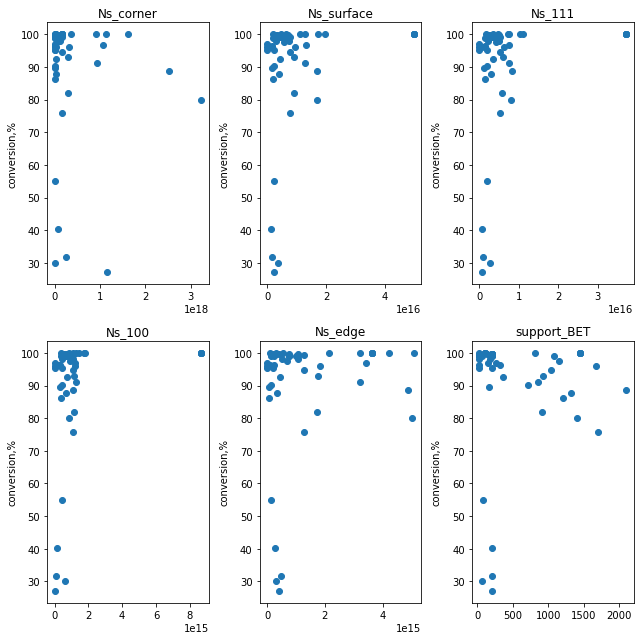

In [349]:
count = 1
max_val = len(Composition_Lattice.mean(axis = 0).sort_values(ascending=False).head(6).keys())
plt.figure(figsize = (9,9))
for element in Composition_Lattice.mean(axis = 0).sort_values(ascending=False).head(6).keys():
    plt.subplot(2,3,count)
    plt.title(element)
    #plt.xlabel('molar amount,%')
    plt.ylabel('conversion,%')
    plt.scatter(Composition_Lattice[element],CBA_conversion)
    count += 1
plt.tight_layout()


# Unsurpervised learning

## K-Means clustering

/var/folders/3_/kgrnccyn4n77ykmt4ms99z800000gn/T/ipykernel_2068/666117795.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Composition_cleaned = Composition.fillna(value = 0).astype(np.float)


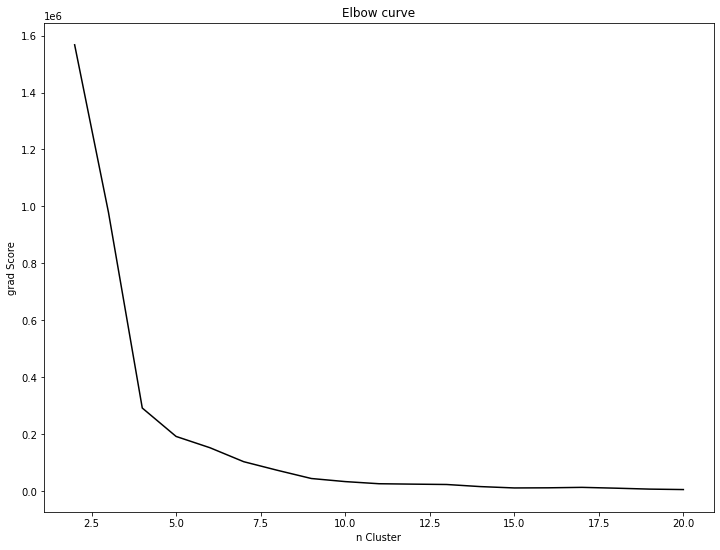

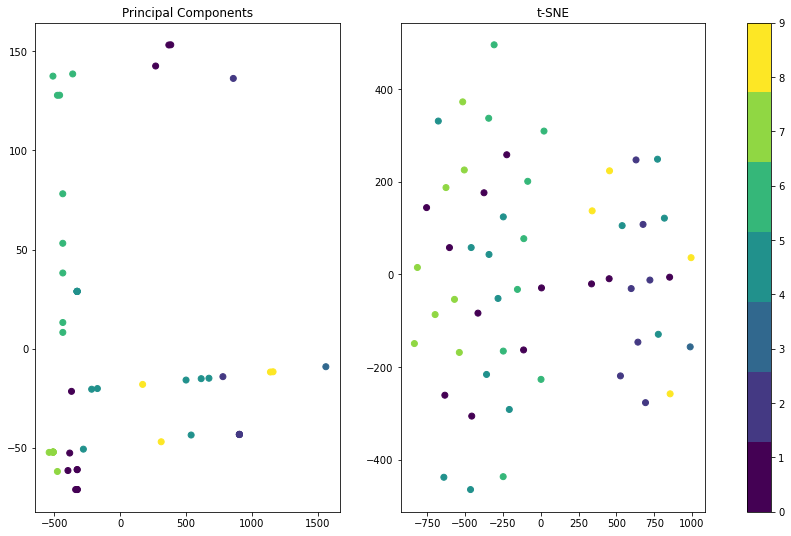

In [44]:
Composition_cleaned = Composition.fillna(value = 0).astype(np.float)

k_ellbow = []
for E in range(2,21):
    kmeans = KMeans(n_clusters=E)
    kmeans.fit(Composition_cleaned)
    score = kmeans.score(Composition_cleaned)
    k_ellbow.append(score)

plt.figure(figsize=(12,9))
plt.title('Elbow curve')
plt.xlabel('n Cluster')
plt.ylabel('grad Score')
plt.plot(range(2,21),np.gradient(k_ellbow),'k')
plt.show()

cluster = KMeans(n_clusters=10)
cluster.fit(Composition_cleaned)
cluster_predictions = cluster.predict(Composition_cleaned)

pca = PCA(n_components=2)
reducer_01 = pca.fit_transform(Composition_cleaned)

tsne = TSNE(n_components=2, random_state= 42, init= 'pca')
reducer_02 = tsne.fit_transform(Composition_cleaned)

fig, axs = plt.subplots(1,2,figsize=(15,9))
axs[0].set_title('Principal Components')
axs[1].set_title('t-SNE')
plot1 = axs[0].scatter(reducer_01[:,0], reducer_01[:,1],c = cluster_predictions,
                     cmap = plt.cm.get_cmap('viridis',7)
                      )
plot2 = axs[1].scatter(reducer_02[:,0], reducer_02[:,1],c = cluster_predictions,
                      cmap = plt.cm.get_cmap('viridis',7)
                      )
fig.colorbar(plot2, ax=axs)
plt.show()

# cluster analysis

support_BET


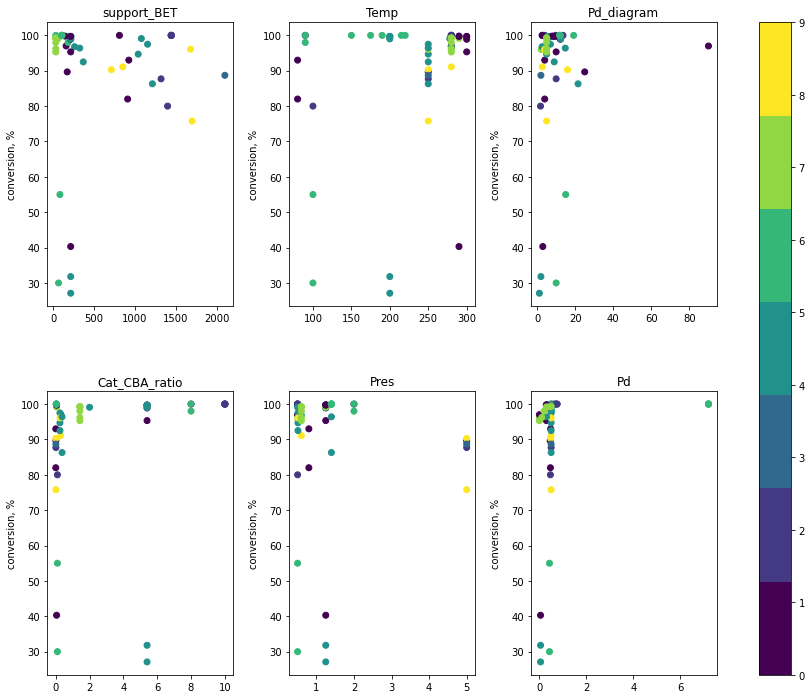

In [45]:
count = 0
elements = Composition.mean(axis = 0).sort_values(ascending=False).head(6).keys()
print(elements[count])
fig,axs = plt.subplots(2,3,figsize = (15,12))
fig.subplots_adjust(wspace = 0.3,hspace = 0.3)
for ax in axs.flat:
    ax.set_title(elements[count])
    ax.set_ylabel('conversion, %')
    plot = ax.scatter(Composition[elements[count]],CBA_conversion,c = cluster_predictions,cmap= plt.cm.get_cmap('viridis',7))
    count += 1
cb = fig.colorbar(plot,ax=axs)


# create train and test data

In [15]:
X = Composition.fillna(value = 0).astype(np.float64)
X_Comosition_Lattice = Composition_Lattice.fillna(value = 0).astype(np.float64)
y = CBA_conversion.fillna(value = 0).astype(np.float64)

#scaler = MinMaxScaler()
#X = scaler.fit_transform(X_Comosition_Lattice)

#print(X)


X_train, X_test, y_train, y_test = train_test_split(X_Comosition_Lattice, y, test_size= 0.1,random_state=42)

# EBM

In [7]:
ebm = ExplainableBoostingRegressor(random_state=1,n_jobs = -1)
y_ebm = ebm.fit(X_train, y_train)
y_ebm_train = y_ebm.predict(X_train)
ebm_global = ebm.explain_global()
show(ebm_global)
ebm_local = ebm.explain_local(X_test, y_test)
show(ebm_local)

<!-- http://127.0.0.1:7496/140352967626416/ -->


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


<!-- http://127.0.0.1:7496/140353087146544/ -->

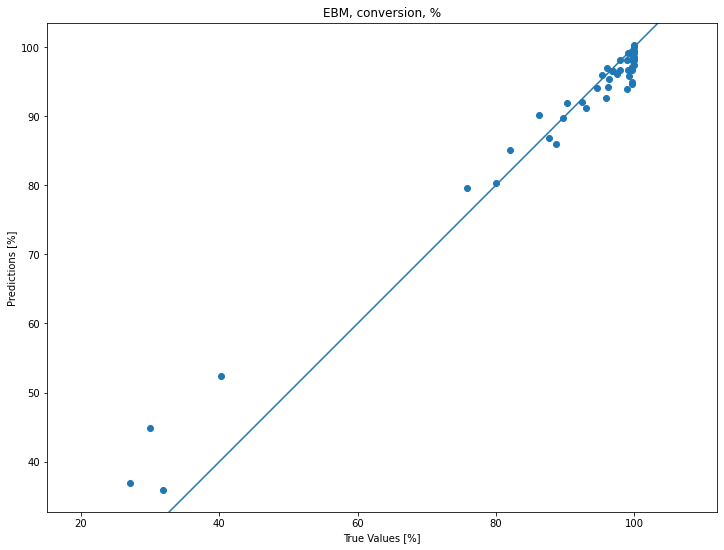

In [451]:
plt.figure(figsize=(12,9))

plt.scatter(y_train, y_ebm_train) 
plt.title('EBM, conversion, %') 
plt.xlabel('True Values [%]') 
plt.ylabel('Predictions [%]') 
plt.axis('equal') 
plt.xlim(plt.xlim()) 
plt.ylim(plt.ylim()) 
plt.plot([-1000, 1000], [-1000, 1000])
plt.show() 

# SVR module

In [376]:
hyper_params_svr = {'gamma':np.random.normal(12,2,10000), 'C':np.random.normal(1,0.2,10000)}

svr_tune = SVR(kernel= 'rbf')
g_search = RandomizedSearchCV(svr_tune, hyper_params_svr,cv=5, n_jobs= -1, random_state= 500)
g_search.fit(X_train, y_train)
#print('Best Estimator', g_search.best_estimator_)
best_C = g_search.best_estimator_.C
best_gamma = g_search.best_estimator_.gamma

svr_rbf = SVR(kernel = 'rbf',C = best_C, gamma= best_gamma)

y_svr = svr_rbf.fit(X_train, y_train)
predict_svr_train = y_svr.predict(X_train)
predict_svr = y_svr.predict(X_test)

print('Score on training set:', y_svr.score(X_train,y_train))
print('Score on test set:', y_svr.score(X_test,y_test))

Score on training set: -0.11174810483839814
Score on test set: -0.2144176053883451


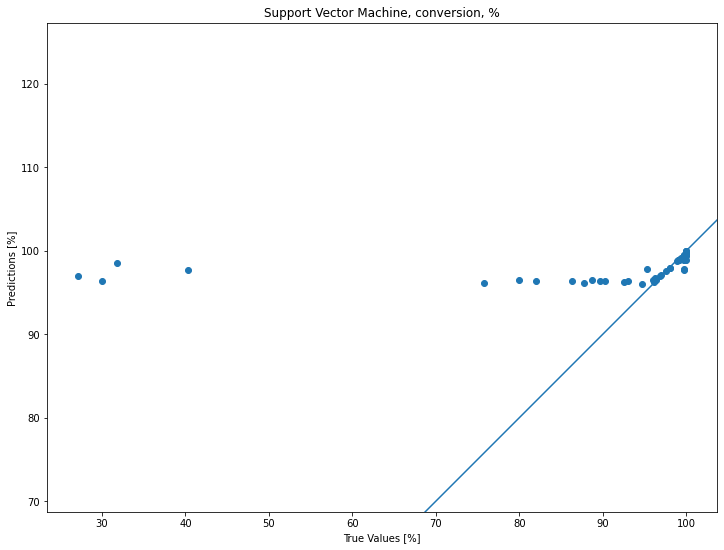

In [377]:
plt.figure(figsize=(12,9))

plt.scatter(y_train, predict_svr_train) 
plt.title('Support Vector Machine, conversion, %') 
plt.xlabel('True Values [%]') 
plt.ylabel('Predictions [%]') 
plt.axis('equal') 
plt.xlim(plt.xlim()) 
plt.ylim(plt.ylim()) 
plt.plot([-1000, 1000], [-1000, 1000])
plt.show() 

# RFG module

In [378]:
hyper_params_rdf = {'n_estimators': np.arange(1,25,1)}

rdf_tune = RandomForestRegressor()
g_search_rdf = RandomizedSearchCV(rdf_tune, hyper_params_rdf, cv=5, n_jobs = -1,random_state=1000)
g_search_rdf.fit(X_train,y_train)
#print('Best Estimator', g_search_rdf.best_estimator_)

estimator = g_search_rdf.best_estimator_.n_estimators
regressor = RandomForestRegressor(n_estimators= estimator)
regressor.fit(X_train,y_train)
y_pred_train = regressor.predict(X_train)
y_pred = regressor.predict(X_test)
print('Score on train set:',regressor.score(X_train,y_train))
print('Score on test set:',regressor.score(X_test,y_test))

Score on train set: 0.9027398797278936
Score on test set: -0.11419111843982144


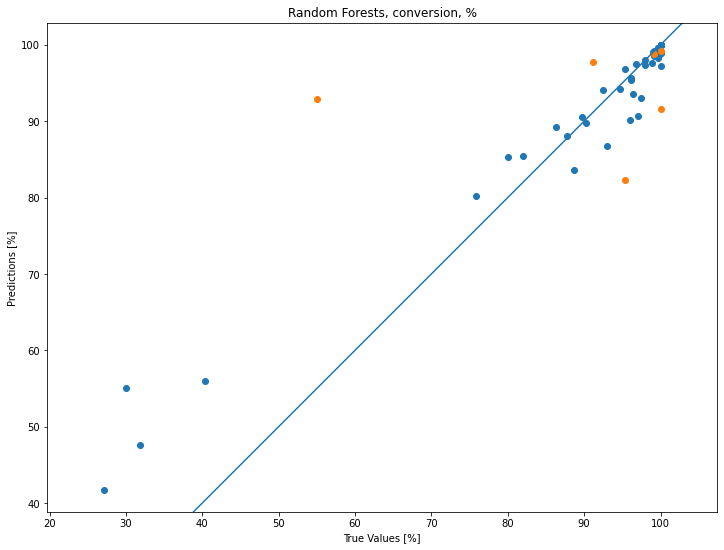

In [379]:
plt.figure(figsize=(12,9))
plt.scatter(y_train, y_pred_train)
plt.scatter(y_test,y_pred)
plt.title('Random Forests, conversion, %') 
plt.xlabel('True Values [%]') 
plt.ylabel('Predictions [%]') 
plt.axis('equal') 
plt.xlim(plt.xlim()) 
plt.ylim(plt.ylim()) 
plt.plot([-1000, 1000], [-1000, 1000])

# XGB module

In [28]:
# xgb ranges
range_depth = [5, 6, 7, 8, 9]
range_subsample = [0.8, 0.9, 1]
range_colsample = [0.8, 0.9, 1]
range_lr = [0.2, 0.1, 0.05, 0.02]

cv_xgb = GridSearchCV(
    XGBRegressor(random_state=100), 
    param_grid={"max_depth": range_depth, 
                "subsample": range_subsample, 
                "colsample_bytree": range_colsample,
                "learning_rate": range_lr})

cv_xgb.fit(X_train, y_train)

cvdepth = cv_xgb.best_params_['max_depth']
cvsubsample = cv_xgb.best_params_['subsample']
cvcolsample = cv_xgb.best_params_['colsample_bytree']
cvlr = cv_xgb.best_params_['learning_rate']

print(cvdepth, cvsubsample, cvcolsample, cvlr)

9 1 0.8 0.2


In [29]:
estimator = XGBRegressor(n_estimators=150,\
                       max_depth=cvdepth,\
                       subsample=cvsubsample,\
                       colsample_bytree=cvcolsample,\
                       learning_rate=cvlr,\
                       random_state=40, seed=40, n_jobs=-1)
print(estimator)

best_xgb_estimator = estimator



y_xgb = best_xgb_estimator.fit(X_train, y_train)
predict_xgb_train = y_xgb.predict(X_train)
predict_xgb = y_xgb.predict(X_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=150, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=40,
             reg_alpha=None, reg_lambda=None, ...)


In [9]:
X_input_test = Composition.iloc[54:60,:]
print(X_input_test)
y_predict_test = y_xgb.predict(X_input_test)
print(y_predict_test)

Empty DataFrame
Columns: [Pd, Ru, Pt, Ni, Sn, Fe, precursor_Cl, precursor_NO3, precursor_Oac, support_AC, support_NC, support_BC, support_TiO2, support_CNT, support_CNF, support_rGo, support_BET, V_total, V_micro, Cat_CBA_ratio, sythesize_IWI, sythesize_core_shell, colloid, Pd_diagram, Temp, Pres]
Index: []

[0 rows x 26 columns]


ValueError: Feature shape mismatch, expected: 29, got 26

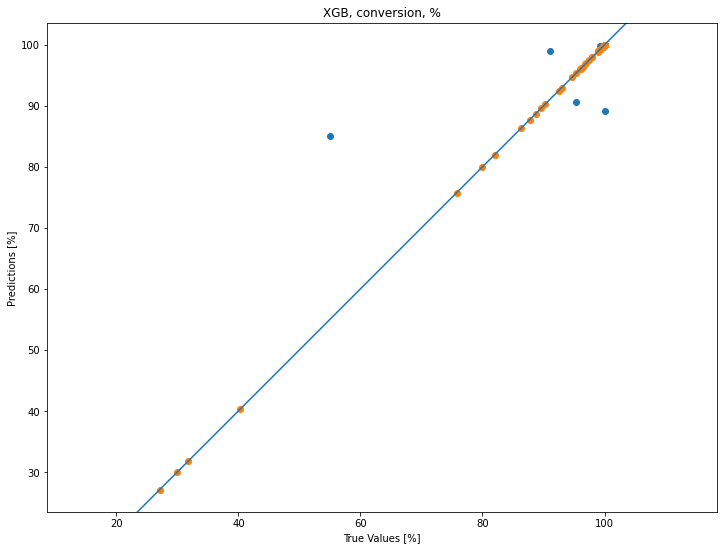

In [30]:
plt.figure(figsize=(12,9))
#fig,axs = plt.subplots(figsize = (12,9))
plt.scatter(y_test, predict_xgb)
plt.scatter(y_train, predict_xgb_train)
plt.title('XGB, conversion, %') 
plt.xlabel('True Values [%]') 
plt.ylabel('Predictions [%]') 
plt.axis('equal') 
plt.xlim(plt.xlim()) 
plt.ylim(plt.ylim()) 
plt.plot([-1000, 1000], [-1000, 1000])
plt.show() 

In [31]:
print('Score on train set:',best_xgb_estimator.score(X_train,y_train))
print('Score on test set:',best_xgb_estimator.score(X_test,y_test))

Score on train set: 0.9999999986105701
Score on test set: 0.28419860461923907


# SHAP

/Users/luowei/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



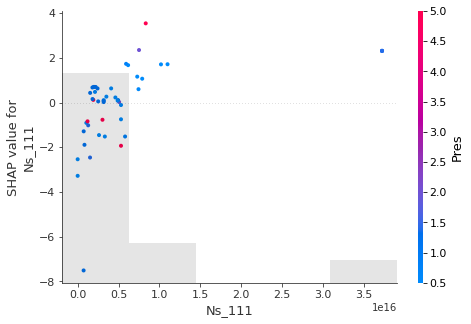

In [32]:
explainer = shap.Explainer(y_xgb)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[0])
shap.initjs()
#shap.plots.force(shap_values[0])
#shap.plots.force(shap_values)
shap.plots.scatter(shap_values[:,"Ns_111"], color = shap_values)
#shap.plots.beeswarm(shap_values)

# learning curve

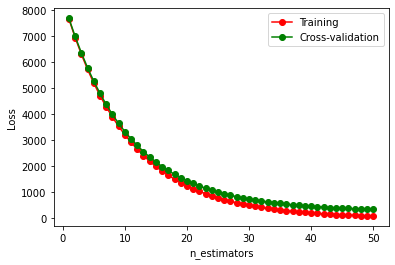

In [384]:
n_estimators = 50
estimator_range = range(1,n_estimators+1)
train_loss, test_loss = validation_curve(
    best_xgb_estimator, X, y,param_name = 'n_estimators',param_range = estimator_range, cv=10, scoring='neg_mean_squared_error')
train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)
plt.plot(estimator_range, train_loss_mean, 'o-', color="r",
         label="Training")
plt.plot(estimator_range, test_loss_mean, 'o-', color="g",
        label="Cross-validation")

plt.xlabel("n_estimators")
plt.ylabel("Loss")
plt.legend(loc="best")

# MLPRegressor

In [415]:
#hyper_params_MLP = {'hidden_layer_sizes': np.arange(1,25,1),}
#rdf_tune = RandomForestRegressor()
#g_search_rdf = RandomizedSearchCV(rdf_tune, hyper_params_rdf, cv=5, n_jobs = -1,random_state=1000)
#g_search_rdf.fit(X_train,y_train)
#print('Best Estimator', g_search_rdf.best_estimator_)
mlp_tuned_parameters = {"hidden_layer_sizes":[(3),(5,),(8),(10,)],
                        "activation":['identity','logistic','tanh','relu'],
                        "solver":['adam','sgd','lbfgs'],
                       "max_iter":[1000],"tol":[1e-5]}
mlp = MLPRegressor()
mlp_estimator = GridSearchCV(mlp,mlp_tuned_parameters,n_jobs = -1)
mlp_estimator.fit(X_train,y_train)
print(mlp_estimator.best_params_)

mlp_hidden_layer_sizes = mlp_estimator.best_params_['hidden_layer_sizes']
mlp_activation = mlp_estimator.best_params_['activation']
mlp_solver = mlp_estimator.best_params_['solver']
mlp_max_iter = mlp_estimator.best_params_['max_iter']
mlp_tol = mlp_estimator.best_params_['tol']



/Users/luowei/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/luowei/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/luowei/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/luowei/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/luowei/op

{'activation': 'tanh', 'hidden_layer_sizes': (5,), 'max_iter': 1000, 'solver': 'sgd', 'tol': 1e-05}


In [424]:
mlp = MLPRegressor(hidden_layer_sizes=mlp_hidden_layer_sizes, 
                 solver=mlp_solver, alpha=0.0001,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.001, power_t=0.5, max_iter= mlp_max_iter,
                   tol=mlp_tol)
y_mlp = mlp.fit(X_train, y_train)
predict_mlp_train = y_mlp.predict(X_train)
predict_mlp_test =y_mlp.predict(X_test)
print('Score on training set:', y_mlp.score(X_train,y_train))
print('Score on Test set:',y_mlp.score(X_test,y_test))

Score on training set: 0.7367595602110034
Score on Test set: 0.4681901756418797


/Users/luowei/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


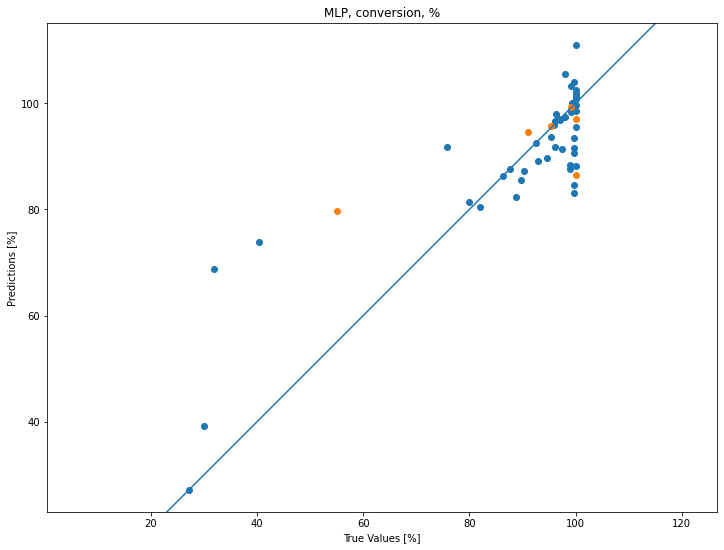

In [425]:
plt.figure(figsize=(12,9))
#fig,axs = plt.subplots(figsize = (12,9))
plt.scatter(y_train, predict_mlp_train)
plt.scatter(y_test, predict_mlp_test)
plt.title('MLP, conversion, %') 
plt.xlabel('True Values [%]') 
plt.ylabel('Predictions [%]') 
plt.axis('equal') 
plt.xlim(plt.xlim()) 
plt.ylim(plt.ylim()) 
plt.plot([-200,200], [-200, 200])
plt.show() 

# mean_squared_error

In [215]:
mse_xgb_train = mean_squared_error(y_train, predict_xgb_train)
mse_xgb_test = mean_squared_error(y_test, predict_xgb)
mse_rdf_train = mean_squared_error(y_train,y_pred_train)
mse_rdf_test = mean_squared_error(y_test,y_pred)
mse_svr_train = mean_squared_error(y_train,predict_svr_train)
mse_svr_test = mean_squared_error(y_test, predict_svr)
print(mse_xgb_train)

2.1801385582335366


# r2 score

In [201]:
r2_xgb_train = r2_score(y_train,predict_xgb_train)
r2_xgb_test = r2_score(y_test, predict_xgb)
r2_rdf_train = r2_score(y_train,y_pred_train)
r2_rdf_test = r2_score(y_test,y_pred)
r2_svr_train = r2_score(y_train,predict_svr_train)
r2_svr_test = r2_score(y_test,predict_svr)

# Plot bars diagram

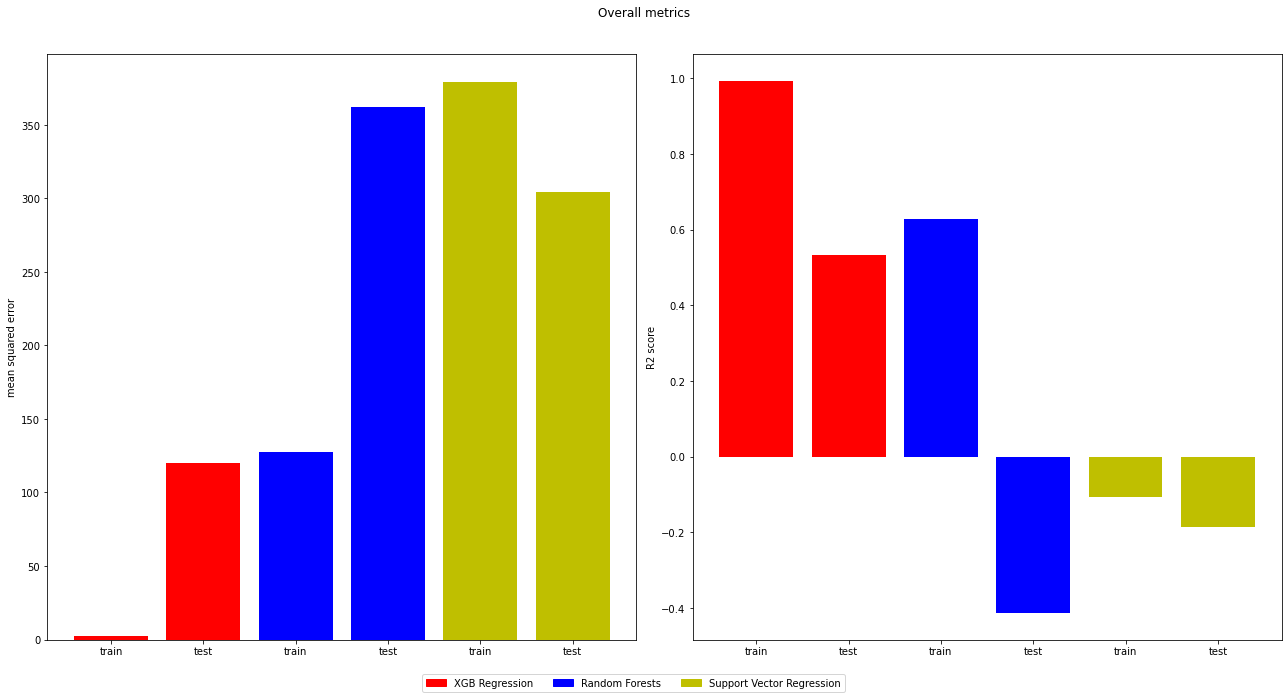

In [202]:
xgb = mpatches.Patch(color= 'r', label = 'XGB Regression')
ann = mpatches.Patch(color= 'b', label = 'Random Forests')
svr = mpatches.Patch(color='y',label= 'Support Vector Regression')

names = ['train','test','train','test','train','test']
pos = range(len(names))
colors = ['r','r','b','b','y','y']
rotation = 0

plt.figure(figsize=(18,9))
plt.suptitle('Overall metrics',y=1.02)
plt.subplot(121)
plt.bar(pos,[mse_xgb_train,mse_xgb_test,mse_rdf_train,mse_rdf_test,mse_svr_train,mse_svr_test],color = colors)
plt.xticks(pos, names, rotation=rotation)
plt.ylabel('mean squared error')

plt.subplot(122)
plt.bar(pos,[r2_xgb_train,r2_xgb_test,r2_rdf_train,r2_rdf_test,r2_svr_train,r2_svr_test],color = colors)
plt.xticks(pos,names,rotation = rotation)
plt.ylabel('R2 score')

plt.tight_layout()
plt.legend(loc = 'upper center', handles = [xgb, ann, svr], ncol=3, bbox_to_anchor = (-0.1, -0.05))
plt.show()



<BarContainer object of 10 artists>

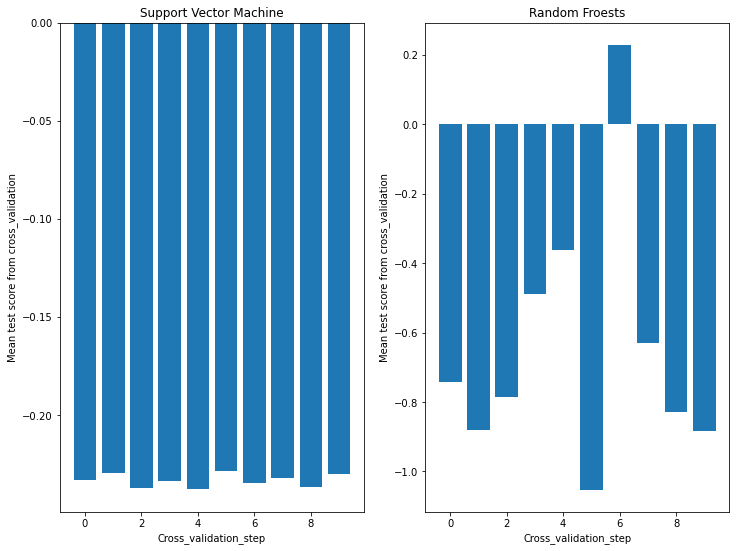

In [182]:
svr_mean_cv_score = g_search.cv_results_['mean_test_score']
rdf_mean_cv_score = g_search_rdf.cv_results_['mean_test_score']

plt.figure(figsize = (12,9))
plt.subplot(121)
plt.xlabel('Cross_validation_step')
plt.ylabel('Mean test score from cross_validation')
plt.title('Support Vector Machine')
plt.bar(x = range(0,len(svr_mean_cv_score)), height = svr_mean_cv_score )
plt.subplot(122)
plt.xlabel('Cross_validation_step')
plt.ylabel('Mean test score from cross_validation')
plt.title('Random Froests')
plt.bar(x = range(0,len(rdf_mean_cv_score)), height = rdf_mean_cv_score )



# cross validation set example

In [203]:
cross_validate(best_xgb_estimator, X_train, y_train,cv=5)

{'fit_time': array([0.07282209, 0.01232004, 0.01146173, 0.01071692, 0.01299405]),
 'score_time': array([0.00221992, 0.00153685, 0.00142717, 0.00132203, 0.00143218]),
 'test_score': array([-0.55623453,  0.51427299, -1.73324745, -0.99041594,  0.25529894])}

# feature importance scores

In [390]:
importance_scores = y_xgb.get_booster().get_score(importance_type='weight')
importance_scores = pd.DataFrame.from_dict(importance_scores, orient = 'index')
importance_scores_rank = importance_scores.mean(axis=1).sort_values(ascending=True).to_frame()
names = importance_scores_rank.index.values.tolist()
scores = importance_scores_rank.iloc[:,0]
print(scores)


f28      1.0
f23      6.0
f17      6.0
f13      7.0
f27      7.0
f9       8.0
f22     10.0
f11     12.0
f12     12.0
f26     16.0
f0      17.0
f5      17.0
f10     36.0
f8      37.0
f15     52.0
f18     68.0
f1      71.0
f25     72.0
f16    104.0
f24    169.0
Name: 0, dtype: float64


([<matplotlib.axis.YTick at 0x7febcf3362b0>,
 [Text(0, 0, 'f28'),
  Text(0, 1, 'f23'),
  Text(0, 2, 'f17'),
  Text(0, 3, 'f13'),
  Text(0, 4, 'f27'),
  Text(0, 5, 'f9'),
  Text(0, 6, 'f22'),
  Text(0, 7, 'f11'),
  Text(0, 8, 'f12'),
  Text(0, 9, 'f26'),
  Text(0, 10, 'f0'),
  Text(0, 11, 'f5'),
  Text(0, 12, 'f10'),
  Text(0, 13, 'f8'),
  Text(0, 14, 'f15'),
  Text(0, 15, 'f18'),
  Text(0, 16, 'f1'),
  Text(0, 17, 'f25'),
  Text(0, 18, 'f16'),
  Text(0, 19, 'f24')])

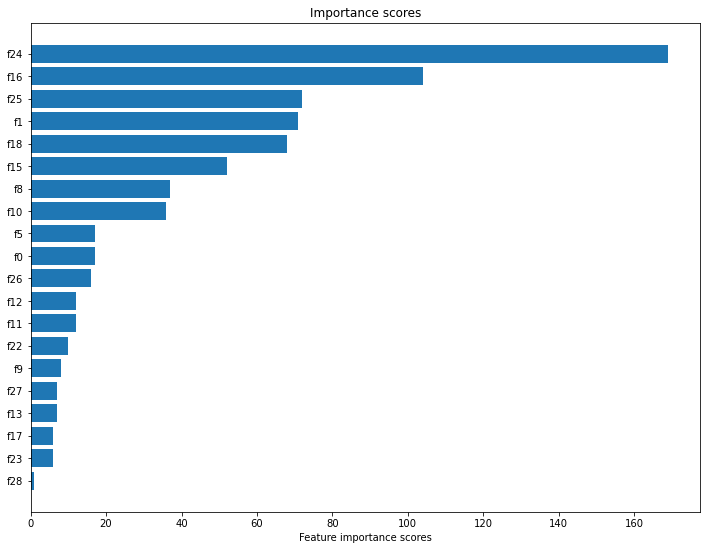

In [391]:
plt.figure(figsize = (12,9))

pos = range(len(names))
plt.xlabel('Feature importance scores')
plt.title('Importance scores')
plt.barh(pos, scores)
plt.yticks(pos,names)

